In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from util import *
%load_ext autoreload
%aimport util
%autoreload 1

In [2]:
annotations = load_annotations()

In [3]:
for name, info in annotations.items():
    masks = np.expand_dims(info['visibility'], axis=2)
    full_mask = np.all(masks, axis=0, keepdims=True)
    info['full_mask'] = full_mask
    visible_coords = info['coords'].astype(np.float32) * masks
    x_min, y_min, x_max, y_max = info['same_bbox']
    info['shift'] = visible_coords[:1]
    info['scale'] = np.array([[[x_max - x_min, y_max - y_min]]])
    info['normed_coords'] = (visible_coords - info['shift']) * info['full_mask'] / info['scale']
    info['coords'] = np.round(info['coords']).astype(int)

In [4]:
filtered_annos = {name : info for name, info in annotations.items() if info['action'] == 'squat' and info['pose'] == 'left' and info['nframes'] >= 70}
len(filtered_annos.keys())
print(list(filtered_annos.keys()))

['1788', '1789', '1725', '1722', '1782', '1819', '1876', '1845', '1720', '1748', '1844', '1879', '1815', '1816', '1776', '1771', '1812', '1813', '1850', '1838', '1839', '1778', '1737', '1696', '1694', '1659', '1692', '1847', '1759', '1781', '1757', '1756', '1755', '1677', '1670', '1671', '1698', '1746', '1690', '1859', '1793', '1777', '1678', '1863', '1862', '1865', '1864', '1889', '1711', '1794', '1738', '1807', '1728', '1849', '1848', '1704', '1802', '1801', '1707', '1708', '1842', '1827', '1729', '1821', '1846', '1823', '1822', '1843', '1683', '1682', '1680', '1687', '1688', '1760', '1747', '1767', '1661', '1873']


In [5]:
train_annos = {name : info for name, info in filtered_annos.items() if info['train']}
test_annos = {name : info for name, info in filtered_annos.items() if not info['train']}

In [6]:
L = 13 # num of joints
k = 15 # training num
T = 45 # prediction num
H = 1024 # hidden layer size

In [7]:
def RNN(p):
    # p should be shape (batch_size, T, 2 * L)
    # unstack gets us a list of T (batch_size, 2 * L) tensors
    batch_size = tf.shape(p)[0]
    p = tf.unstack(p, k, axis=1)
    lstm_cell = rnn.BasicLSTMCell(H, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, p, dtype=tf.float32)
    
    output_state = rnn.LSTMStateTuple(states[-1], outputs[-1])
    lstm_cell_pred = rnn.BasicLSTMCell(H, forget_bias=1.0, reuse=True)
    outputs, states = rnn.static_rnn(lstm_cell_pred, [tf.zeros((batch_size, L*2))] * T, initial_state=output_state, dtype=tf.float32)
    
    # outputs is a list of T (batch_size, H) arrays
    # concat outputs is (batch_size * T, H)
    concat_outputs = tf.concat(outputs, axis=0)
    
    W1 = tf.get_variable('W1', shape=[H, 100], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', shape=[100], dtype=tf.float32, initializer=tf.zeros_initializer())

    W2 = tf.get_variable('W2', shape=[100, L * 2], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', shape=[L * 2], dtype=tf.float32, initializer=tf.zeros_initializer())

    # predictions is (batch_size * T, 2 * L)
    predictions = tf.nn.sigmoid(tf.matmul(concat_outputs, W1) + b1)
    predictions = tf.nn.tanh(tf.matmul(predictions, W2) + b2)
    
    # reshape into (T, batch_size, 2 * L) then transpose into (batch_size, T, 2 * L)
    return tf.transpose(tf.reshape(predictions, (T, batch_size, L * 2)), perm=[1, 0, 2])

In [8]:
tf.reset_default_graph()
sess = tf.Session()

learning_rate = 5e-4

global_step = tf.get_variable('global_step', initializer=0, trainable=False)
p_input = tf.placeholder(tf.float32, shape=[None, k, L * 2])
p_output = tf.placeholder(tf.float32, shape=[p_input.get_shape()[0], T, L * 2])

p_output_predicted = RNN(p_input)

# Define loss and optimizer
loss = tf.reduce_mean(tf.squared_difference(p_output_predicted, p_output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [9]:
max_steps = 4000
batch_size = 1
n_videos = len(train_annos)
display_step = 10
save_step = 250

losses = []
g_step = tf.train.global_step(sess, global_step)
while g_step < max_steps:
    inputs, expected_outputs = [], []
    for name, info in train_annos.items():
        coords = info['normed_coords']
        start_time = np.random.randint(len(coords) - (k + T) + 1)
        inputs.append(coords[start_time : start_time + k].reshape(k, 2 * L))
        expected_outputs.append(coords[start_time + k : start_time + k + T].reshape(T, 2 * L))
    _, loss_value = sess.run((optimizer, loss), feed_dict={
        p_input : np.asarray(inputs),
        p_output : np.asarray(expected_outputs)
    })
    losses.append(loss_value)
    g_step = tf.train.global_step(sess, global_step)
    if g_step % display_step == 0:
        print('epoch %s: loss=%.8f' % (g_step, np.mean(losses)))
        losses = []
    if g_step % save_step == 0:
        saver.save(sess, Models + 'lstm/default/train/model.ckpt', global_step=g_step)

epoch 10: loss=0.1587
epoch 20: loss=0.0152
epoch 30: loss=0.0111
epoch 40: loss=0.0091
epoch 50: loss=0.0087
epoch 60: loss=0.0085
epoch 70: loss=0.0085
epoch 80: loss=0.0085
epoch 90: loss=0.0085
epoch 100: loss=0.0085
epoch 110: loss=0.0085
epoch 120: loss=0.0086
epoch 130: loss=0.0085
epoch 140: loss=0.0086
epoch 150: loss=0.0084
epoch 160: loss=0.0084
epoch 170: loss=0.0084
epoch 180: loss=0.0084
epoch 190: loss=0.0085
epoch 200: loss=0.0084
epoch 210: loss=0.0084
epoch 220: loss=0.0083
epoch 230: loss=0.0084
epoch 240: loss=0.0084
epoch 250: loss=0.0084
epoch 260: loss=0.0083
epoch 270: loss=0.0086
epoch 280: loss=0.0083
epoch 290: loss=0.0082
epoch 300: loss=0.0082
epoch 310: loss=0.0081
epoch 320: loss=0.0082
epoch 330: loss=0.0081
epoch 340: loss=0.0080
epoch 350: loss=0.0079
epoch 360: loss=0.0077
epoch 370: loss=0.0079
epoch 380: loss=0.0078
epoch 390: loss=0.0074
epoch 400: loss=0.0074
epoch 410: loss=0.0074
epoch 420: loss=0.0066
epoch 430: loss=0.0063
epoch 440: loss=0.00

epoch 3470: loss=0.0001
epoch 3480: loss=0.0001
epoch 3490: loss=0.0003
epoch 3500: loss=0.0002
epoch 3510: loss=0.0002
epoch 3520: loss=0.0002
epoch 3530: loss=0.0001
epoch 3540: loss=0.0001
epoch 3550: loss=0.0001
epoch 3560: loss=0.0001
epoch 3570: loss=0.0001
epoch 3580: loss=0.0001
epoch 3590: loss=0.0001
epoch 3600: loss=0.0001
epoch 3610: loss=0.0001
epoch 3620: loss=0.0001
epoch 3630: loss=0.0001
epoch 3640: loss=0.0001
epoch 3650: loss=0.0001
epoch 3660: loss=0.0001
epoch 3670: loss=0.0001
epoch 3680: loss=0.0001
epoch 3690: loss=0.0001
epoch 3700: loss=0.0001
epoch 3710: loss=0.0001
epoch 3720: loss=0.0001
epoch 3730: loss=0.0001
epoch 3740: loss=0.0001
epoch 3750: loss=0.0001
epoch 3760: loss=0.0001
epoch 3770: loss=0.0001
epoch 3780: loss=0.0001
epoch 3790: loss=0.0001
epoch 3800: loss=0.0001
epoch 3810: loss=0.0001
epoch 3820: loss=0.0001
epoch 3830: loss=0.0001
epoch 3840: loss=0.0001
epoch 3850: loss=0.0001
epoch 3860: loss=0.0001
epoch 3870: loss=0.0001
epoch 3880: loss

In [36]:
sess.close()

In [9]:
saver.restore(sess, Models + 'lstm/default/train/model.ckpt-4000')

INFO:tensorflow:Restoring parameters from /home/jeffz/video_prediction/models/lstm/default/train/model.ckpt-4000


In [12]:
paired_annos = list(filtered_annos.items())
inputs, outputs = [], []
for name, info in paired_annos:
    coords = info['normed_coords']
    inputs.append(coords[:k].reshape(k, 2 * L))
    
outputs = sess.run(p_output_predicted, feed_dict={ p_input : np.asarray(inputs) }).reshape(len(paired_annos), T, L, 2)

for (name, info), output in zip(paired_annos, outputs):
    info['output_coords'] = np.round((output * info['scale'] + info['shift']) * info['full_mask']).astype(int)    

In [13]:
print('Train', train_annos.keys())
print('Test', test_annos.keys())

Train ['1788', '1789', '1722', '1782', '1778', '1821', '1823', '1879', '1738', '1777', '1776', '1771', '1813', '1819', '1737', '1696', '1694', '1678', '1759', '1757', '1677', '1670', '1711', '1863', '1865', '1760', '1807', '1802', '1801', '1707', '1708', '1847', '1846', '1720', '1822', '1683', '1682', '1748', '1746', '1747', '1767', '1661']
Test ['1781', '1876', '1873', '1815', '1816', '1812', '1850', '1838', '1839', '1659', '1692', '1690', '1756', '1755', '1671', '1698', '1859', '1793', '1794', '1862', '1864', '1889', '1849', '1848', '1704', '1728', '1729', '1843', '1842', '1827', '1725', '1845', '1844', '1680', '1687', '1688']


<IPython.core.display.Javascript object>


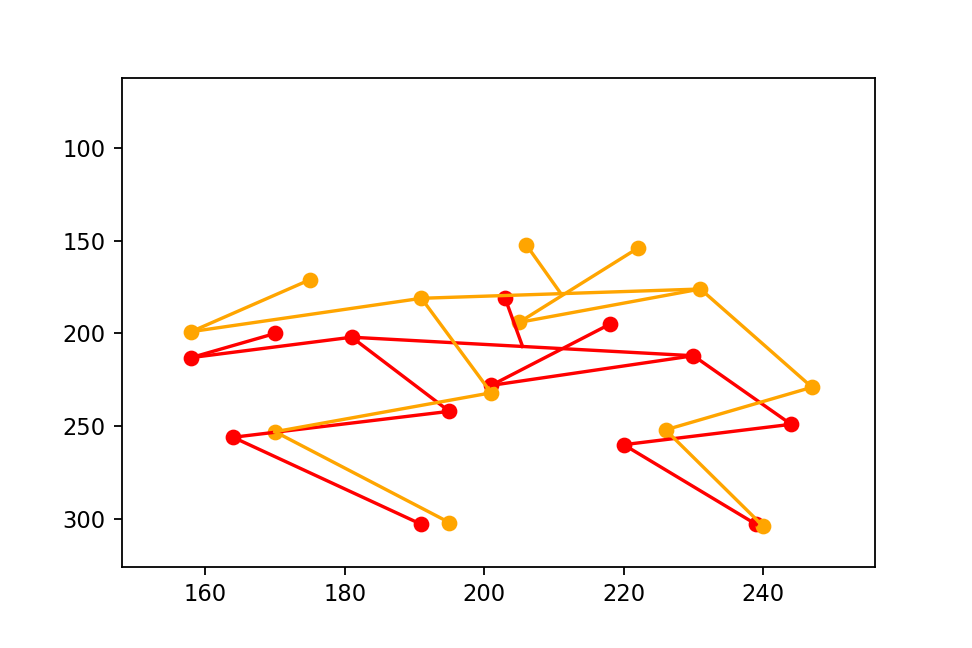

In [14]:
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation, cm

video_number = '1781'
if video_number in train_annos:
    

info = annotations['1781']
x_min, y_min, x_max, y_max = info['same_bbox']
poses = [info['output_coords'], info['coords'][k : k + T]]
visibilities = [x.astype(np.bool) for x in info['full_mask'][:, :, 0] * np.ones((T, 1)), info['visibility'][k : k + T]]

fig = plt.figure()
ax = plt.axes(xlim=(x_min, x_max), ylim=(y_min, y_max))
plt.gca().invert_yaxis()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'cyan', 'magenta', 'violet', 'black']
points = [ax.plot([], [], 'o', color=colors[i])[0] for i in range(len(poses))]

connections = [[0, [1, 2]], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [1, 7], [2, 8], [7, 9], [9, 11], [8, 10], [10, 12]]
segments = [[ax.plot([], [], '-', color=colors[i])[0] for _ in connections] for i in range(len(poses))]

def init():
    [point.set_data([], []) for point in points]
    [[segment.set_data([], []) for segment in frame_segments] for frame_segments in segments]
    return points + [segment for frame_segments in segments for segment in frame_segments]

def animate(t):
    [point.set_data(*pose[t][visibility[t]].T) for point, pose, visibility in zip(points, poses, visibilities)]
    for frame_segments, pose, visibility in zip(segments, poses, visibilities):
        for connection, segment in zip(connections, frame_segments):
            if not np.all(visibility[t][connection[0]]) or not np.all(visibility[t][connection[1]]):
                segment.set_data([], [])
                continue
            means = []
            for endpoints in connection:
                ps = pose[t][endpoints]
                ps = ps.reshape((ps.size // 2, 2))
                means.append(np.mean(ps, axis=0))
            segment.set_data(zip(*means))
    return points + [segment for vid_segment in segments for segment in vid_segment]
nframes = min(len(pose) for pose in poses)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=nframes, blit=True)
# anim.save('results/test_%s.mp4' % vid_num, fps=15)
plt.show()